In [1]:
"""
 Convolutional AutoEncoder
"""
import tensorflow as tf
import tensorflow.examples.tutorials.mnist.input_data as input_data
import matplotlib.pyplot as plt
import numpy as np
import math
%matplotlib inline 

mnist = input_data.read_data_sets("data/", one_hot=True)

trainimgs   = mnist.train.images
trainlabels = mnist.train.labels
testimgs    = mnist.test.images
testlabels  = mnist.test.labels

ntrain      = trainimgs.shape[0]
ntest       = testimgs.shape[0]
dim         = trainimgs.shape[1]
nout        = trainlabels.shape[1]

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [2]:
# Define convolutional auto-encoder (CAE)

n1 = 10
n2 = 20
n3 = 30

weights = {
    'ce1': tf.Variable(tf.random_normal([3, 3, 1, n1], stddev=0.1)),
    'ce2': tf.Variable(tf.random_normal([3, 3, n1, n2], stddev=0.1)),
    'ce3': tf.Variable(tf.random_normal([3, 3, n2, n3], stddev=0.1)),
    'cd3': tf.Variable(tf.random_normal([3, 3, n2, n3], stddev=0.1)),
    'cd2': tf.Variable(tf.random_normal([3, 3, n1, n2], stddev=0.1)),
    'cd1': tf.Variable(tf.random_normal([3, 3, 1, n1], stddev=0.1))
}

biases = {
    'be1': tf.Variable(tf.random_normal([n1], stddev=0.1)),
    'be2': tf.Variable(tf.random_normal([n2], stddev=0.1)),
    'be3': tf.Variable(tf.random_normal([n3], stddev=0.1)),
    'bd3': tf.Variable(tf.random_normal([n2], stddev=0.1)),
    'bd2': tf.Variable(tf.random_normal([n1], stddev=0.1)),
    'bd1': tf.Variable(tf.random_normal([1], stddev=0.1))
}
def cae(_X, _W, _b):
    _input_r = tf.reshape(_X, shape=[-1, 28, 28, 1])
    
    # Encoder
    _ce1 = tf.nn.relu(
        tf.add(
            tf.nn.conv2d(_input_r, _W['ce1'], strides=[1, 2, 2, 1], padding='SAME')
            , _b['be1']
        ))
    _ce2 = tf.nn.relu(
        tf.add(
            tf.nn.conv2d(_ce1, _W['ce2'], strides=[1, 2, 2, 1], padding='SAME')
            , _b['be2']
        )) 
    _ce3 = tf.nn.relu(
        tf.add(
            tf.nn.conv2d(_ce2, _W['ce3'], strides=[1, 2, 2, 1], padding='SAME')
            , _b['be3']
        )) 
    
    # Decoder
    _cd3 = tf.nn.relu(
        tf.add(
            tf.nn.conv2d_transpose(_ce3, _W['cd3']
                , tf.pack([tf.shape(_X)[0], 7, 7, n2])
                , strides=[1, 2, 2, 1], padding='SAME')
            , _b['bd3']
        )) 
    _cd2 = tf.nn.relu(
        tf.add(
            tf.nn.conv2d_transpose(_cd3, _W['cd2'] # <== ERROR!
                , tf.pack([tf.shape(_X)[0], 14, 14, n1])
                , strides=[1, 2, 2, 1], padding='SAME') 
            , _b['bd2']
        )) 
    _cd1 = tf.nn.relu(
        tf.add(
            tf.nn.conv2d_transpose(_cd2, _W['cd1']
                , tf.pack([tf.shape(_X)[0], 28, 28, 1])
                , strides=[1, 2, 2, 1], padding='SAME')
            , _b['bd1']
        )) 
    _out = _cd1
    return {'input_r': _input_r
            , 'ce1': _ce1, 'ce2': _ce2, 'ce3': _ce3
            , 'cd3': _cd3, 'cd2': _cd2, 'cd1': _cd1
            , 'layers': (_input_r, _ce1, _ce2, _ce3, _cd3, _cd2, _cd1)
            , 'out': _out}

# Define functions
x = tf.placeholder(tf.float32, [None, dim])
pred = cae(x, weights, biases)['out']
cost = tf.reduce_sum(tf.square(cae(x, weights, biases)['input_r'] 
            - cae(x, weights, biases)['out']))
learning_rate = 0.001
optm = tf.train.AdamOptimizer(learning_rate).minimize(cost)
init = tf.initialize_all_variables()


In [3]:

# We create a session to use the graph
sess = tf.Session()
sess.run(init)

# %%
mnist = input_data.read_data_sets('data', one_hot=True)
mean_img = np.mean(mnist.train.images, axis=0)

# Fit all training data
batch_size = 100
n_epochs   = 10
print("Strart training..")
for epoch_i in range(n_epochs):
    for batch_i in range(mnist.train.num_examples // batch_size):
        batch_xs, _ = mnist.train.next_batch(batch_size)
        train = np.array([img - mean_img for img in batch_xs])
        sess.run(optm, feed_dict={x: train})
    print(epoch_i, "/", n_epochs, sess.run(cost, feed_dict={x: train}))

print("Training done. ")


Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
Strart training..
0 / 10 5075.16
1 / 10 5273.01
2 / 10 5206.49
3 / 10 5219.0
4 / 10 5178.62
5 / 10 5555.27
6 / 10 5293.04
7 / 10 5006.39
8 / 10 5570.47
9 / 10 5271.06
Training done. 


(10, 28, 28, 1)


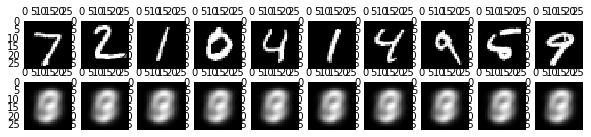

layer 0's shape is (1, 28, 28, 1)
layer 1's shape is (1, 14, 14, 10)
layer 2's shape is (1, 7, 7, 20)
layer 3's shape is (1, 4, 4, 30)
layer 4's shape is (1, 7, 7, 20)
layer 5's shape is (1, 14, 14, 10)
layer 6's shape is (1, 28, 28, 1)


In [4]:
# Plot example reconstructions
n_examples = 10
test_xs, _ = mnist.test.next_batch(n_examples)
test_xs_norm = np.array([img - mean_img for img in test_xs])
recon = sess.run(pred, feed_dict={x: test_xs_norm})
print(recon.shape)
fig, axs = plt.subplots(2, n_examples, figsize=(10, 2))
for example_i in range(n_examples):
    axs[0][example_i].matshow(
        np.reshape(test_xs[example_i, :], (28, 28)), cmap=plt.get_cmap('gray'))
    axs[1][example_i].matshow(
        np.reshape(
            np.reshape(recon[example_i, ...], (784,)) + mean_img,
            (28, 28)), cmap=plt.get_cmap('gray'))
plt.draw()
plt.show()

test_xs, _ = mnist.test.next_batch(1)
test_xs_norm = np.array([img - mean_img for img in test_xs])
recon = sess.run(pred, feed_dict={x: test_xs_norm})
layers = sess.run(cae(x, weights, biases)['layers'], feed_dict={x: test_xs_norm})
for i in range(len(layers)):
    currl = layers[i]
    print (("layer %d's shape is %s") % (i, currl.shape,))
